In [1]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM Master
        """

    # Execute the query and get the result as a DataFrame
    costreport_df = sql_executor.execute_query(query)

costreport_df.info()

df = costreport_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97191 entries, 0 to 97190
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   prov_id                      97191 non-null  object 
 1   year                         97191 non-null  int64  
 2   ownership                    97191 non-null  object 
 3   chow_last_12mos              96973 non-null  object 
 4   state                        96973 non-null  object 
 5   county_ssa                   96973 non-null  float64
 6   zip                          97191 non-null  object 
 7   loc_type                     97083 non-null  object 
 8   has_outpatient               97191 non-null  object 
 9   num_beds                     96880 non-null  float64
 10  snf_num_beds                 96867 non-null  float64
 11  snf_admis_tot                96109 non-null  float64
 12  tot_days                     96874 non-null  float64
 13  snf_days_total  

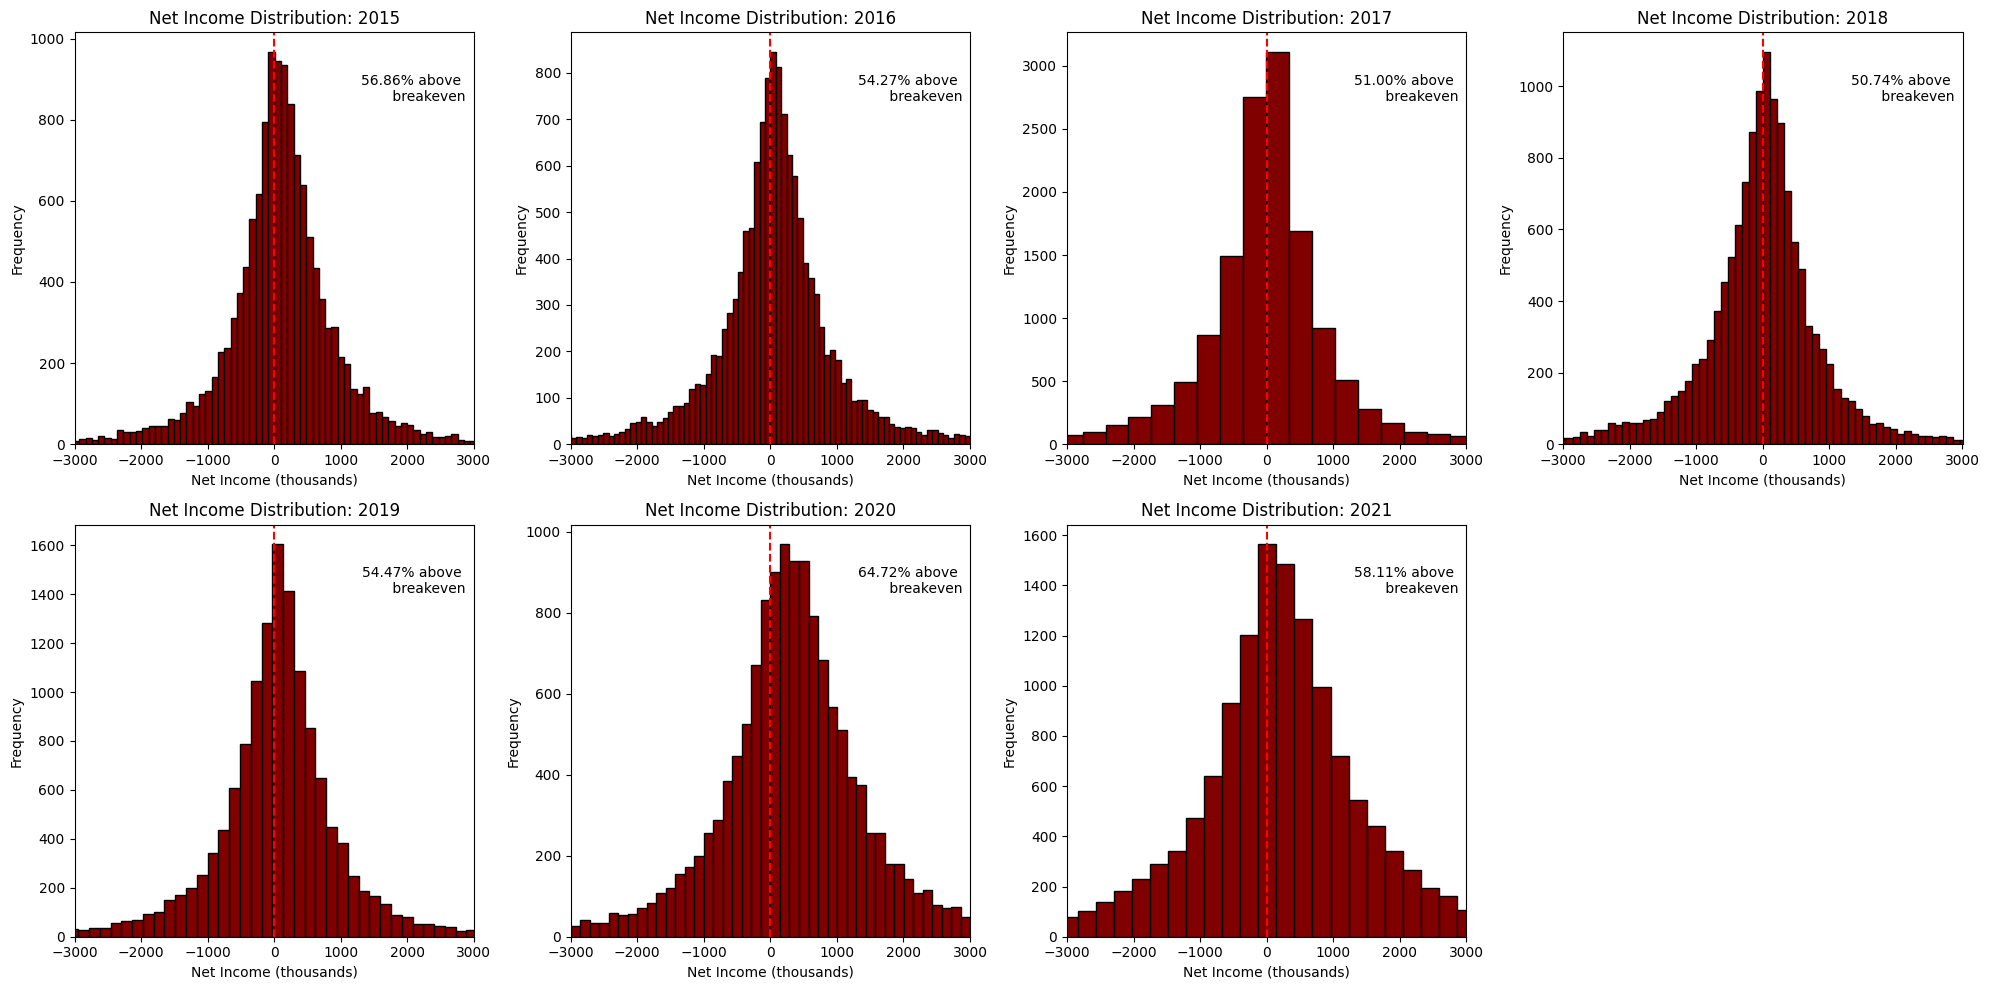

In [2]:
import matplotlib.pyplot as plt

net_income = costreport_df[['year','net_income']]
net_income_dict = {}

for fiscal_year, group_data in net_income.groupby('year'):

    # Extract net_income values and convert to a list
    net_income_dict[fiscal_year] = group_data['net_income'].dropna().tolist()


# Filter out fiscal year 2022
net_income_filtered_dict = {fiscal_year: net_income_list for fiscal_year, net_income_list in net_income_dict.items() if fiscal_year != 2022}

# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Iterate over the filtered dictionary items and enumerate to get both index and data
for idx, (fiscal_year, net_income_list) in enumerate(net_income_filtered_dict.items()):
    if idx >= 8:  # Limit to the first 8 fiscal years
        break
    
    # Divide net income values by a thousand
    net_income_list = [income / 1000 for income in net_income_list]
    
    # Calculate the position in the grid
    row = idx // 4
    col = idx % 4
    
    # Create a histogram for the current fiscal year in the appropriate subplot
    axs[row, col].hist(net_income_list, bins=1000, color='maroon', edgecolor='black')
    axs[row, col].set_title(f'Net Income Distribution: {fiscal_year}')
    axs[row, col].set_xlabel('Net Income (thousands)')
    axs[row, col].set_ylabel('Frequency')
    
    # Center x-axis at 0
    axs[row, col].set_xlim(-3000, 3000)
    
    # Draw dotted line at x=0
    axs[row, col].axvline(x=0, color='red', linestyle='--')
    axs[row, col].grid(False)
    
    # Calculate percentage of data above 0
    data_above_zero = sum(x > 0 for x in net_income_list)
    total_data_points = len(net_income_list)
    percentage_above_zero = (data_above_zero / total_data_points) * 100
    
    # Annotate plot with percentage above 0
    axs[row, col].annotate(f"{percentage_above_zero:.2f}% above \n breakeven", xy=(0.98, 0.9), xycoords='axes fraction', ha='right', va='top')

# Set the 8th subplot as None (empty space)
axs[1, 3].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

plt.show()

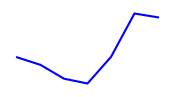

In [4]:
import numpy as np

# Calculate mean net income for each fiscal year
mean_net_income_by_year = {fiscal_year: np.mean(net_income_list) for fiscal_year, net_income_list in net_income_filtered_dict.items()}
years = list(mean_net_income_by_year.keys())
mean_incomes = list(mean_net_income_by_year.values())

# Plot the trend line only
plt.figure(figsize=(2, 1))
plt.plot(years, mean_incomes, color='blue', linewidth=1.5, label='Mean Income')
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine
plt.gca().spines['left'].set_visible(False)  # Hide left spine
plt.legend().set_visible(False)  # Hide legend
plt.show()

/tmp/ipykernel_9298/3239483197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020["net_income_per_bed"] = df_2020["net_income"] / df_2020["num_beds"]


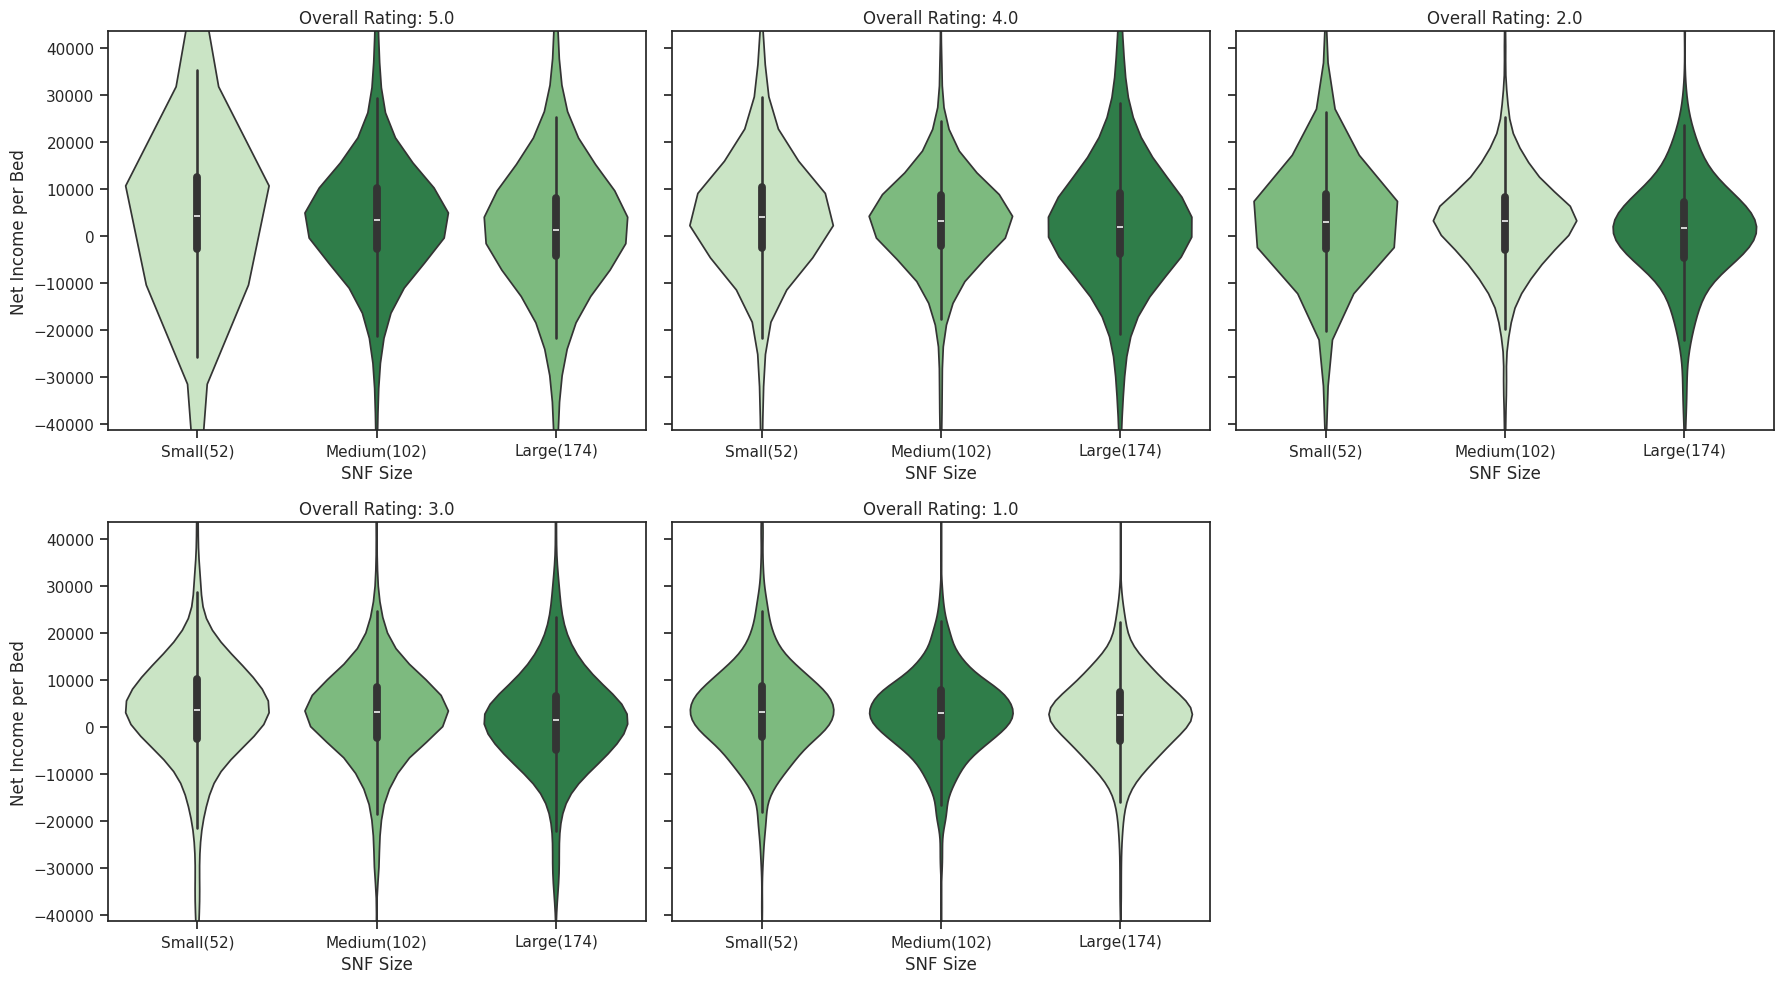

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_theme(style="ticks")

# Define a greenish color palette
redish_palette = sns.color_palette("Reds", 3)

# Filter the DataFrame for fiscal year 2020
df_2020 = df.loc[df['fiscal_year'] == 2020]

# Calculate net income per bed for fiscal year 2020
df_2020["net_income_per_bed"] = df_2020["net_income"] / df_2020["num_beds"]

# Determine the number of unique ratings
unique_ratings = df["overall_rating"].unique()
num_ratings = len(unique_ratings)

# Calculate the number of rows required based on the number of ratings and desired columns
num_rows = math.ceil(num_ratings / 3)

# Define the order of SNF sizes
snf_size_order = ["Small(52)", "Medium(102)", "Large(174)"]

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, num_rows*5), sharey=True)

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterate over ratings and create a violin plot for each
for i, rating in enumerate(unique_ratings):
    row = i // 3
    col = i % 3
    rating_df = df_2020[df_2020["overall_rating"] == rating]
    sns.violinplot(x="snf_size", y="net_income_per_bed", data=rating_df, ax=axes[row, col], hue="snf_size", palette=redish_palette, legend=False, bw_method="silverman", cut=0, order=snf_size_order)
    axes[row, col].set_title(f"Overall Rating: {rating}")
    axes[row, col].set_xlabel("SNF Size")
    axes[row, col].set_ylabel("Net Income per Bed")
    
    # Set y-axis limits
    # Here you can adjust the limits according to your preference
    # This example sets the y-axis limits to the 5th and 95th percentiles of the data
    ylim_min = rating_df["net_income_per_bed"].quantile(0.001)
    ylim_max = rating_df["net_income_per_bed"].quantile(0.999)
    axes[row, col].set_ylim(ylim_min, ylim_max)

# Hide empty subplots
for i in range(num_ratings, num_rows*3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [53]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM CovidVax
        """

    # Execute the query and get the result as a DataFrame
    vax_df = sql_executor.execute_query(query)

vax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30411 entries, 0 to 30410
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   prov_id                    30411 non-null  object
 1   prov_state                 30411 non-null  object
 2   pct_residents_primary_vax  30411 non-null  object
 3   pct_staff_primary_vax      30411 non-null  object
 4   last_update                30411 non-null  object
 5   pct_residents_todate_vax   15147 non-null  object
 6   pct_staff_todate_vax       15147 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [2]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            (operating_income / ((total_assets + total_liabilities) * num_beds)) as roe,
            operating_income,
            gross_revenue,
            year,
            ownership,
            acct_payable,
            acct_rec,
            total_liabilities,
            tot_fund_balance,
            current_ratio,
            quick_ratio,
            pct_fixed_assets,
            pct_other_assets,
            (tot_days / tot_bed_days_avail) as fill_rate,
            cash,
            chow_last_12mos,
            region,
            state,
            state_lean,
            county_ssa,
            zip,
            tot_discharge_tot,
            def_score,
            fine_tot,
            fine_cnt,
            resfamcouncil,
            sprinkler_status,
            overall_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            snf_avg_stay_len_title_tot,
            pop_over_70,
            over_70_pct,
            has_outpatient,
            bedcert,
            fac_type,
            staff_style,
            totlichrd_to_tot
            
            
        FROM Master
        WHERE 
            roa > -1 
            AND roa < 1 
            AND total_assets > 0
            AND total_liabilities > 0 
            AND operating_income < 15000000 
            AND operating_income > -15000000
            AND gross_revenue < 80000000
            AND operating_income < 300000000
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) < .5
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) > -.5
        ORDER BY prov_id;
        """

    # Execute the query and get the result as a DataFrame
    roe = sql_executor.execute_query(query)

roe.describe()

,roe,operating_income,gross_revenue,year,acct_payable,acct_rec,total_liabilities,tot_fund_balance,current_ratio,quick_ratio,...,rnhrd,totlichrd,tothrd,pthrd,weighted_all_cycles_score,snf_avg_stay_len_title_tot,pop_over_70,over_70_pct,bedcert,totlichrd_to_tot
count,62230.000000,6.223000e+04,6.223000e+04,62230.000000,6.223000e+04,6.223000e+04,6.223000e+04,6.223000e+04,62230.000000,62230.000000,...,62230.000000,62230.000000,62230.000000,62230.000000,61791.000000,62230.000000,62230.000000,62230.000000,62230.000000,62230.000000
mean,0.095900,9.229137e+05,1.125656e+07,2018.142471,1.043200e+04,2.289097e+04,1.760742e+05,3.885328e+04,16.315484,10.649278,...,0.717623,1.581388,3.970331,0.084982,59.999422,2.172562,83383.798120,0.120123,0.959626,0.398037
std,0.179714,2.789501e+06,8.177047e+06,2.023361,4.979935e+04,1.251397e+05,7.365846e+05,3.233008e+05,2372.577500,2195.853569,...,0.400662,0.483408,0.869868,0.092759,68.365254,12.578852,167950.656378,0.030283,1.066348,0.071421
min,-0.499937,-1.499900e+07,-2.740000e+03,2015.000000,-2.538404e+05,-3.438439e+05,1.692434e-01,-1.005025e+07,-7359.016509,-7186.550314,...,0.000000,0.000000,1.503410,0.000000,0.000000,0.000004,139.000000,0.030065,0.000010,0.000000
25%,-0.010477,-1.075872e+05,5.806636e+06,2016.000000,1.735060e+03,6.557765e+03,1.292708e+04,-4.820244e+03,0.740018,0.009655,...,0.465570,1.300000,3.423682,0.032890,20.667000,0.727976,5882.000000,0.099888,1.000000,0.354324
50%,0.071062,6.327625e+05,9.152945e+06,2018.000000,3.623174e+03,1.017734e+04,3.034245e+04,9.025190e+03,1.321670,0.124987,...,0.642130,1.508450,3.826800,0.066175,40.000000,1.248264,21951.000000,0.116816,1.000000,0.395980
75%,0.213288,1.866713e+06,1.420777e+07,2020.000000,7.879764e+03,1.555954e+04,8.218412e+04,3.571065e+04,2.582680,0.678328,...,0.877722,1.761170,4.373577,0.106770,74.000000,2.328741,84179.000000,0.135020,1.000000,0.438039
max,0.499967,1.499058e+07,7.941304e+07,2022.000000,3.165168e+06,7.913870e+06,3.752557e+07,1.869957e+07,554139.333333,546469.166667,...,8.012500,9.983330,16.326920,3.320740,1442.330000,2987.234623,953730.000000,0.446093,200.000000,1.000005


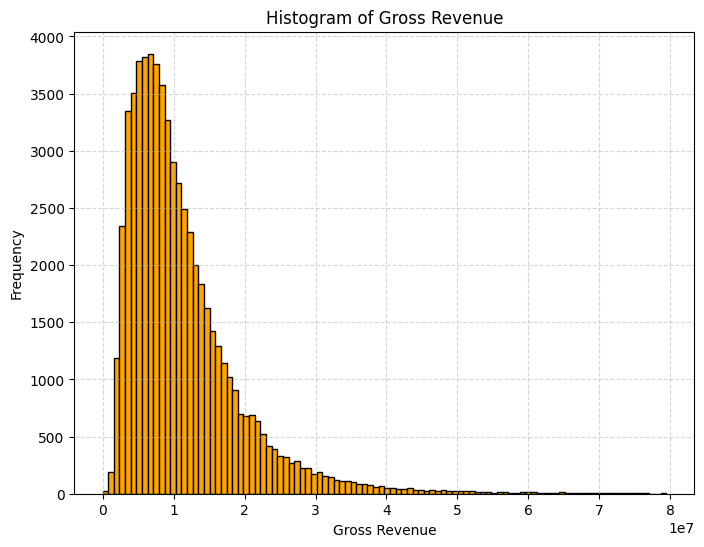

In [3]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(8, 6))
plt.hist(roe['gross_revenue'], bins=100, color='orange', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Gross Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Gross Revenue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [49]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            prov_id, contract_labor, tot_salaries_adjusted, RIGHT(fiscal_start,4) as fiscal_year
        FROM 
            CostReports
        WHERE
            prov_id IN (075329, 075221, 075350, 075415) AND RIGHT(fiscal_start,4) in (2019,2020)
        ORDER BY prov_id, fiscal_start;
        """

    # Execute the query and get the result as a DataFrame
    bristol = sql_executor.execute_query(query)

bristol.describe()

,contract_labor,tot_salaries_adjusted
count,7.000000e+00,8.000000e+00
mean,7.719266e+05,6.517440e+06
std,4.970418e+05,1.004781e+06
min,4.326000e+04,5.450472e+06
25%,4.623445e+05,5.936974e+06
50%,1.016380e+06,6.317878e+06
75%,1.111754e+06,6.686066e+06
max,1.195649e+06,8.445434e+06


In [24]:
print(bristol[['pop_over_70','prov_id','fine_tot','fac_type','net_income', 'total_debt', '']])

    pop_over_70 prov_id    fine_tot    fac_type  net_income  total_debt
0       21722.0  075221    8.371212  short_term    426823.0   4779464.0
1       21722.0  075221    8.371212  short_term    -54084.0   4779464.0
2       21722.0  075221    8.371212    med_term   -192326.0   4779464.0
3       21722.0  075221   54.166667    med_term    131046.0   4779464.0
4       21722.0  075221   54.166667    med_term    245070.0   4779464.0
5       21722.0  075221   54.166667    med_term    273393.0   4779464.0
6       21722.0  075221   54.166667    med_term   1341533.0   4779464.0
7       21722.0  075329    9.140625    med_term   -309507.0   4779464.0
8       21722.0  075329    9.140625    med_term   1137218.0   4779464.0
9       21722.0  075329    0.000000    med_term    961384.0   4779464.0
10      21722.0  075329    0.000000  short_term    857238.0   4779464.0
11      21722.0  075329    0.000000    med_term  -1312466.0   4779464.0
12      21722.0  075329    0.000000    med_term   -292882.0   47

IndexError: index 2 is out of bounds for axis 0 with size 2

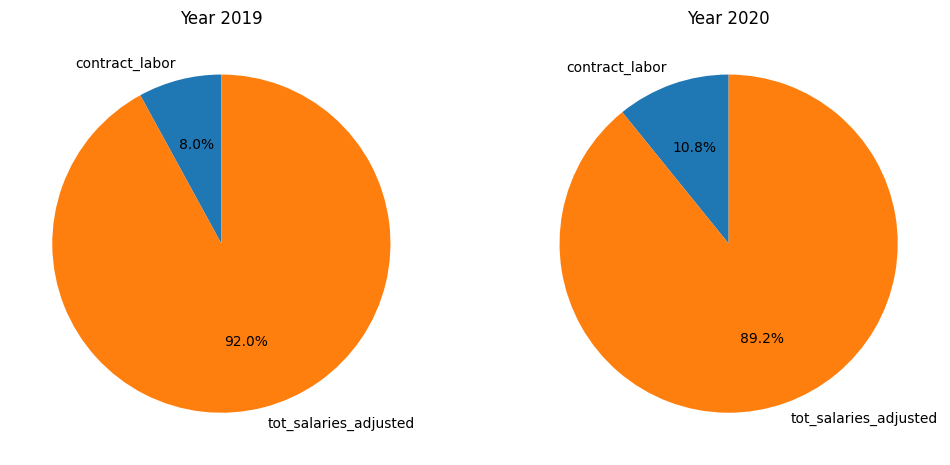

In [50]:
# Calculate the sum of 'contract_labor' and 'tot_salaries_adjusted' for each year
sum_by_year = bristol.groupby('fiscal_year')[['contract_labor', 'tot_salaries_adjusted']].sum()

# Plot a pie chart for each year
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots for each year

for i, year in enumerate(['2019', '2020', '2021']):
    ax = axes[i]
    year_data = sum_by_year.loc[year]
    ax.pie(year_data, labels=year_data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Year {year}')

plt.suptitle('Distribution of Contract Labor and Total Adjusted Salaries for 2019 and 2020')
plt.show()

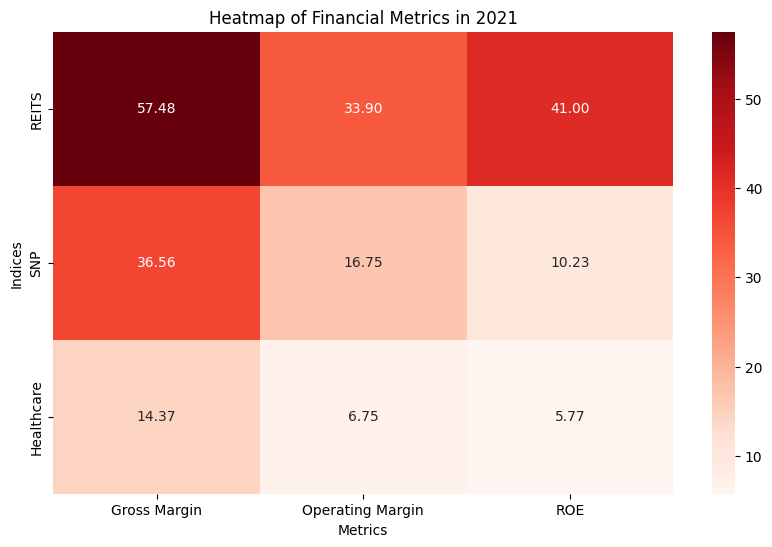

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
                    'Index' : ['REITS','SNP','Healthcare'],
                    'Gross Margin': [57.48,36.56,14.37],
                    'Operating Margin': [33.9,16.75,6.75],
                    'ROE': [41, 10.23, 5.77]
                    
})

# Set the 'Index' column as index
df.set_index('Index', inplace=True)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='Reds', annot=True, fmt=".2f")
plt.title('Heatmap of Financial Metrics in 2021')
plt.xlabel('Metrics')
plt.ylabel('Indices')
plt.show()

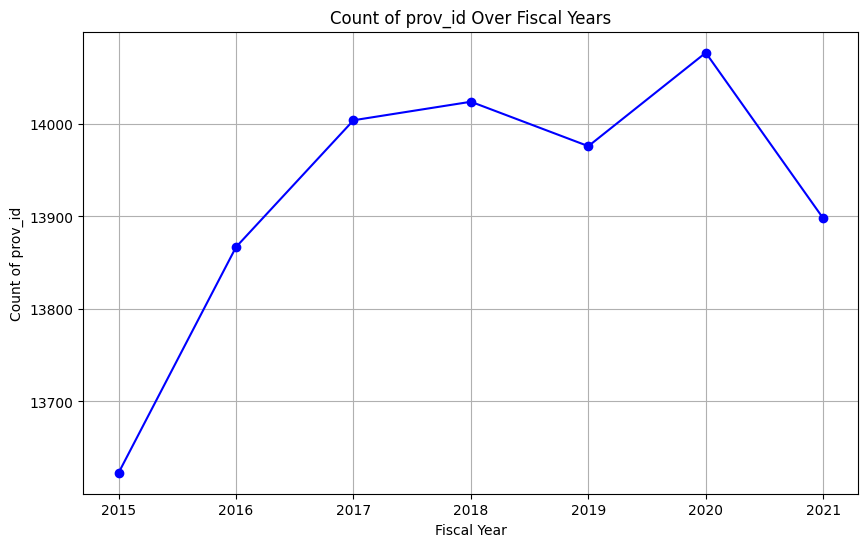

In [57]:
# Provided data
counts = [13623, 13867, 14004, 14024, 13976, 14077, 13898]
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', color='b', linestyle='-')
plt.title('Count of prov_id Over Fiscal Years')
plt.xlabel('Fiscal Year')
plt.ylabel('Count of prov_id')
plt.grid(True)
plt.xticks(years)  # Ensure all years are shown on the x-axis
plt.show()